In [1]:
pip install keras-vggface==0.5

  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     |████████████████████████████████| 14.8 MB 824 kB/s            
  Created wheel for keras-vggface: filename=keras_vggface-0.5-py3-none-any.whl size=7238 sha256=ce4d13c239c3f0a7379784fcc494504cbfafad23ff16084125d7c2fc4dde62b8
  Stored in directory: /root/.cache/pip/wheels/14/80/4d/0c6b9c5d457c9f5b2c4dbff1d5d02a12ed9106240acb447f08
  Created wheel for wrapt: filename=wrapt-1.12.1-cp37-cp37m-linux_x86_64.whl size=77041 sha256=5c71869955c15ee77940962db347e1fc52c53c74db7f6c0720f0186a86676afa
  Stored in directory: /root/.cache/pip/wheels/62/76/4c/aa25851149f3f6d9785f6c869387ad82b3fd37582fa8147ac6
Successfully built keras-vggface wrapt
  Attempting uninstall: typing-extensions
    Found existing installation: typing-extensions 3.10.0.2
    Uninstalling typing-extensions-3.10.0.2:
      Successfully uninstalled typing-extensions-3.10.0.2
  Attempting uninstall: six
    Found existing installation: six 1.16.

In [3]:
!pip install keras_applications

     |████████████████████████████████| 50 kB 449 kB/s            


In [8]:
filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('from keras.applications.imagenet_utils import _obtain_input_shape', 'from keras_applications.imagenet_utils import _obtain_input_shape'))

20756

In [10]:
filename = "/opt/conda/lib/python3.7/site-packages/keras_vggface/models.py"
text = open(filename).read()
open(filename, "w+").write(text.replace('keras.engine.topology', 'tensorflow.keras.utils'))

20757

In [11]:
from keras_applications.imagenet_utils import _obtain_input_shape
from keras_vggface.vggface import VGGFace

In [12]:
import cv2
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow
from sklearn import metrics
import keras_vggface
from keras_vggface.vggface import VGGFace
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Dropout
from keras.callbacks import ReduceLROnPlateau

from tensorflow.keras.optimizers import Adam, RMSprop
from keras.preprocessing.image import ImageDataGenerator


In [13]:
def get_random_eraser(p=0.5, s_l=0.02, s_h=0.4, r_1=0.3, r_2=1/0.3, v_l=0, v_h=255, pixel_level=False):
    def eraser(input_img):
        if input_img.ndim == 3:
            img_h, img_w, img_c = input_img.shape
        elif input_img.ndim == 2:
            img_h, img_w = input_img.shape

        p_1 = np.random.rand()

        if p_1 > p:
            return input_img

        while True:
            s = np.random.uniform(s_l, s_h) * img_h * img_w
            r = np.random.uniform(r_1, r_2)
            w = int(np.sqrt(s / r))
            h = int(np.sqrt(s * r))
            left = np.random.randint(0, img_w)
            top = np.random.randint(0, img_h)

            if left + w <= img_w and top + h <= img_h:
                break

        if pixel_level:
            if input_img.ndim == 3:
                c = np.random.uniform(v_l, v_h, (h, w, img_c))
            if input_img.ndim == 2:
                c = np.random.uniform(v_l, v_h, (h, w))
        else:
            c = np.random.uniform(v_l, v_h)

        input_img[top:top + h, left:left + w] = c

        return input_img

    return eraser

In [31]:
base_path = "../input/140k-real-and-fake-faces/real_vs_fake/real-vs-fake/"
batch_size=64
image_gen =  ImageDataGenerator(
        rescale = 1./255.,
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,
        preprocessing_function=get_random_eraser(v_l=0, v_h=1, pixel_level=False))


train_flow= image_gen.flow_from_directory(
    base_path + 'train/',
    target_size = (224, 224),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode ='binary'
)
valid_flow = image_gen.flow_from_directory(
    base_path + 'valid/',
    target_size = (224, 224),
    batch_size = batch_size,
    #color_mode='grayscale',
    class_mode = 'binary'
)
test_flow = image_gen.flow_from_directory(
    base_path + 'test/',
    target_size = (224, 224),
    batch_size = 1,
    shuffle = False,
    #color_mode='grayscale',
    class_mode ='binary'
)

Found 100000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.
Found 20000 images belonging to 2 classes.


In [32]:
vgg_model = VGGFace(include_top=False, input_shape = (224,224,3))

last_layer = vgg_model.get_layer('pool5').output
flat_layer = Flatten(name='flatten')(last_layer)
fc1 = Dense(2048, activation='relu', name='fc1')(flat_layer)
dense2 = Dense(1, activation='sigmoid', name='dense2')(fc1)

custom_vgg_model = Model(vgg_model.input, dense2)

In [33]:
custom_vgg_model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 224, 224, 64)      1792      
_________________________________________________________________
conv1_2 (Conv2D)             (None, 224, 224, 64)      36928     
_________________________________________________________________
pool1 (MaxPooling2D)         (None, 112, 112, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2_2 (Conv2D)             (None, 112, 112, 128)     147584    
_________________________________________________________________
pool2 (MaxPooling2D)         (None, 56, 56, 128)       0   

In [36]:
from tensorflow.keras.optimizers import Adam
opt = Adam(lr=0.0002)
custom_vgg_model.compile(loss='binary_crossentropy',optimizer= opt, metrics=['accuracy'])

In [37]:
from keras.callbacks import ModelCheckpoint
filepath = "saved-final-model.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

In [39]:
train_steps = 100000//100
valid_steps = 20000//100

history = custom_vgg_model.fit_generator(
    train_flow,
    epochs =5,
    callbacks= callbacks_list,
    steps_per_epoch = train_steps,
    validation_data = valid_flow,
    validation_steps = valid_steps
)

Epoch 1/5
1000/1000 [==============================] - 1487s 1s/step - loss: 0.2007 - accuracy: 0.9156 - val_loss: 0.1601 - val_accuracy: 0.9352

Epoch 00001: val_accuracy improved from 0.87422 to 0.93516, saving model to saved-final-model.h5
Epoch 2/5
1000/1000 [==============================] - 1401s 1s/step - loss: 0.1481 - accuracy: 0.9400 - val_loss: 0.1627 - val_accuracy: 0.9370

Epoch 00002: val_accuracy improved from 0.93516 to 0.93703, saving model to saved-final-model.h5
Epoch 3/5
1000/1000 [==============================] - 1352s 1s/step - loss: 0.1244 - accuracy: 0.9501 - val_loss: 0.1105 - val_accuracy: 0.9562

Epoch 00003: val_accuracy improved from 0.93703 to 0.95617, saving model to saved-final-model.h5
Epoch 4/5
1000/1000 [==============================] - 1366s 1s/step - loss: 0.1059 - accuracy: 0.9582 - val_loss: 0.1204 - val_accuracy: 0.9516

Epoch 00004: val_accuracy did not improve from 0.95617
Epoch 5/5
1000/1000 [==============================] - 1378s 1s/step -

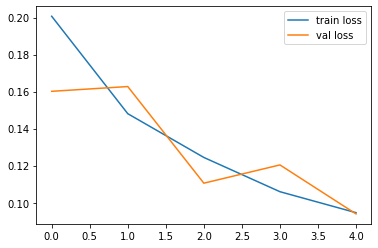

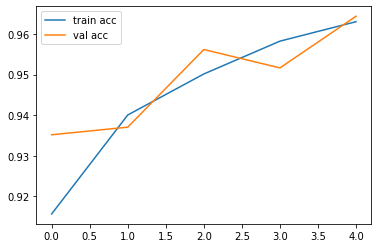

In [47]:
plt.plot(history.history['loss'], label='train loss')
plt.plot(history.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# plot the accuracy
plt.plot(history.history['accuracy'], label='train acc')
plt.plot(history.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()

In [40]:
y_pred = custom_vgg_model.predict(test_flow)
y_test = test_flow.classes

In [41]:
from sklearn import metrics
print("ROC AUC Score:", metrics.roc_auc_score(y_test, y_pred))
print("AP Score:", metrics.average_precision_score(y_test, y_pred))
print()
print(metrics.classification_report(y_test, y_pred > 0.5))

ROC AUC Score: 0.994929935
AP Score: 0.9944838001388516

              precision    recall  f1-score   support

           0       0.97      0.96      0.97     10000
           1       0.96      0.97      0.97     10000

    accuracy                           0.97     20000
   macro avg       0.97      0.97      0.97     20000
weighted avg       0.97      0.97      0.97     20000



In [42]:
y_test1 = np.array(y_test)
y_test1

array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [43]:
y_pred1 = y_pred.copy()
np.where(y_pred1 > 0.5, 1, 0)

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]])

In [44]:
y_pred2 = y_pred1.flatten()
y_pred2 = np.where(y_pred2 > 0.5, 1, 0)
y_pred2

array([1, 0, 0, ..., 1, 1, 1])

In [45]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test,y_pred2)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

[[9643  357]
 [ 333 9667]]
acc: 0.9655
sensitivity: 0.9643
specificity: 0.9667


<AxesSubplot:>

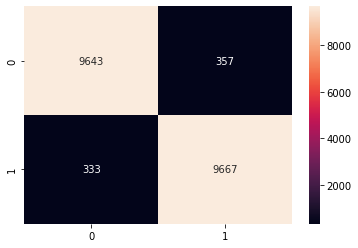

In [46]:
import seaborn as sns
sns.heatmap(cm,annot=True, fmt='g')

In [48]:
train_flow.class_indices

{'fake': 0, 'real': 1}